<a href="https://www.kaggle.com/code/serdargundogdu/gdz-enerji-makine-renmesi-lightgbm?scriptVersionId=126645075" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# İş Problemi

İzmir ve Manisa illerinde günlük yaşamın vazgeçilmezi olan elektrik enerjisini, insan odaklı hizmet anlayışı ve modern teknoloji sistemleri ile tüketicilerine ulaştıran Gdz Elektrik, geleneksel hale getirdiği Datathon serisinin ikincisinin çözümüdür.

Katılımcıların sunulan veri seti ile Gdz Elektrik sorumluluğundaki şebeke merkezlerine yönelik "enerji dağıtım" tahminleme yaklaşımı geliştirilmesi bekleniyor. 🎯

Kaggle yarışmasında başarı metriği MAPE (Mean Absolute Percentage Error) olacaktır.

# Veri Seti Hikayesi ve Değişkenler

Dosya

● med.csv - Major Event Day veri seti

● train.csv - Train veri seti

● sample_submission.csv - Örnek submission dosyası

Açıklamalar

Major Event Day (MED.CSV): Gün içindeki elektrik kesinti süresinin kabul edilebilir limiti aştığı gün.
Dolayısıyla kesinti olduysa o gün tahmin edilen enerjinin sapmasının yüksek olmasını bekleriz. Çünkü kesinti nedeniyle dağıtılamamış.

Dağıtılan Enerji: Watt: Aktif(yararlı) gücün birimi.
MWh = MegaWatt saat

Dağıtılan Enerji'nin %85'i İzmir, %15'i ise Manisa için gerçekleştirilmektedir.

Dış Veri Kullanımı
Size faydalı olabileceğini düşündüğünüz her türlü halka açık veriyi kullanabilirsiniz.

# Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
from sklearn.metrics import mean_absolute_percentage_error

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

# Veri Setinin Keşfi

In [2]:
df_med = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/med.csv', index_col='Tarih', parse_dates=True)
df_train = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/train.csv' , index_col='Tarih', parse_dates=True)
df_test = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/sample_submission.csv', index_col='Tarih', parse_dates=True)
df_all = pd.concat([df_train, df_test], axis=0)
df_all.reset_index(inplace=True)

* df_train veri setinde 1673 günlük 24'er saatlikveri vardır.

     df_train veri seti 2018-01-01 00:00:00 tarihinden 2022-07-31 23:00:00 tarihine kadar veri içermektedir.

* df_test veri setinde 31 günlük 24'er saatlik veri vardır.
    
    df_test veri seti 2022-08-01 00:00:00 tarihinden 2022-08-31 23:00:00 tarihine kadar veri içermektedir. 
    
* df_all veri setinde 1704 günlük 24'er saatlik veri vardır.
    
    df_all veri seti 2018-01-01 00:00:00 tarihinden 2022-08-31 23:00:00 tarihine kadar veri içermektedir. 

    "Dağıtılan Enerji (MWh)" = 0 olanlar df_test 
    
    "Dağıtılan Enerji (MWh)" > 0 olanlar df_train

In [3]:
df_all.head()

,Tarih,Dağıtılan Enerji (MWh)
0,2018-01-01 00:00:00,1593.944216
1,2018-01-01 01:00:00,1513.933887
2,2018-01-01 02:00:00,1402.612637
3,2018-01-01 03:00:00,1278.527266
4,2018-01-01 04:00:00,1220.697701


In [4]:
df_all.tail()

,Tarih,Dağıtılan Enerji (MWh)
40891,2022-08-31 19:00:00,0.0
40892,2022-08-31 20:00:00,0.0
40893,2022-08-31 21:00:00,0.0
40894,2022-08-31 22:00:00,0.0
40895,2022-08-31 23:00:00,0.0


In [5]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Dağıtılan Enerji (MWh),40152.0,1836.805287,426.066085,870.18328,1499.165048,1813.409221,2129.407998,3633.105297


In [6]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [7]:
check_df(df_train)

##################### Shape #####################
(40152, 1)
##################### Types #####################
Dağıtılan Enerji (MWh)    float64
dtype: object
##################### Head #####################
                     Dağıtılan Enerji (MWh)
Tarih                                      
2018-01-01 00:00:00             1593.944216
2018-01-01 01:00:00             1513.933887
2018-01-01 02:00:00             1402.612637
2018-01-01 03:00:00             1278.527266
2018-01-01 04:00:00             1220.697701
##################### Tail #####################
                     Dağıtılan Enerji (MWh)
Tarih                                      
2022-07-31 19:00:00             2492.489498
2022-07-31 20:00:00             2479.958245
2022-07-31 21:00:00             2485.016884
2022-07-31 22:00:00             2396.574255
2022-07-31 23:00:00             2285.252844
##################### NA #####################
Dağıtılan Enerji (MWh)    0
dtype: int64
##################### Quantiles #######

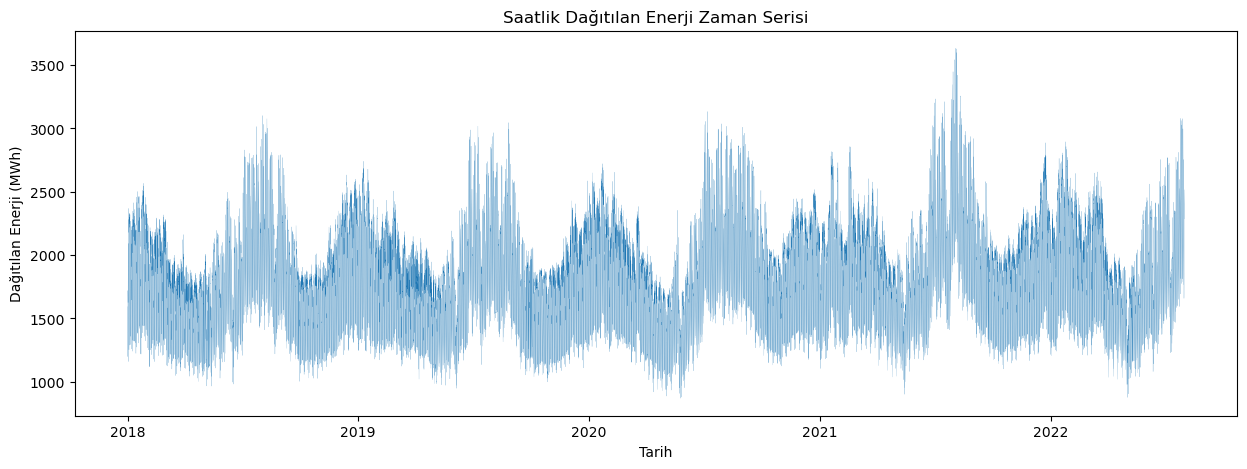

In [8]:
plt.figure(figsize=(15,5))
plt.title("Saatlik Dağıtılan Enerji Zaman Serisi")
plt.plot(df_train["Dağıtılan Enerji (MWh)"],linewidth=0.1)
plt.xlabel("Tarih")
plt.ylabel("Dağıtılan Enerji (MWh)")
plt.show()

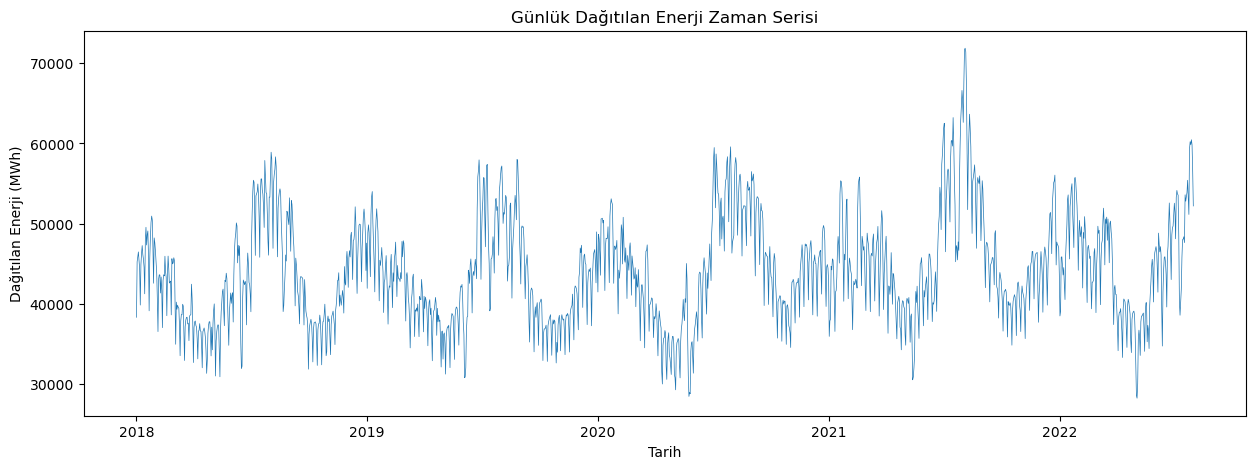

In [9]:
plt.figure(figsize=(15,5))
plt.title("Günlük Dağıtılan Enerji Zaman Serisi")
plt.plot(df_train['Dağıtılan Enerji (MWh)'].resample('D').sum(),linewidth=0.5)
plt.xlabel("Tarih")
plt.ylabel("Dağıtılan Enerji (MWh)")
plt.show()

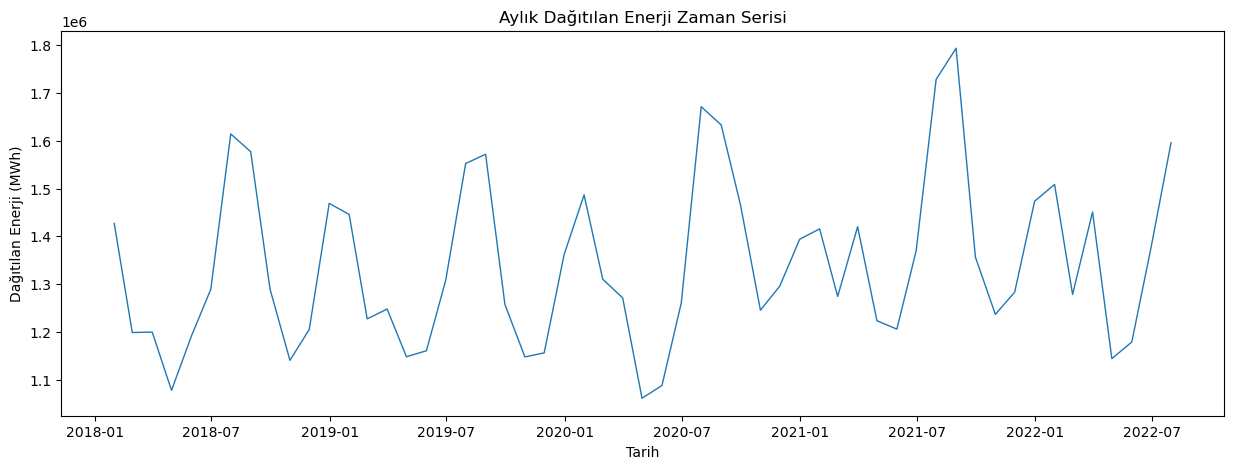

In [10]:
plt.figure(figsize=(15,5))
plt.title("Aylık Dağıtılan Enerji Zaman Serisi")
plt.plot(df_train['Dağıtılan Enerji (MWh)'].resample('M').sum(),linewidth=1)
plt.xlabel("Tarih")
plt.ylabel("Dağıtılan Enerji (MWh)")
plt.show()

# Makine Öğrenmesi ile Çözüm (LightGBM)

Veriler günlük ortalama değerlere çevirilip daha sonra saatlik Ağustos ayı dağılımlarına göre dağıtılacaktır.
2022 Ağustos ayı günleri tahmini için 2021 Ağustos ayı günleri değerleri validasyon verisi olarak alınacaktır.

In [11]:
train = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/train.csv', parse_dates=['Tarih'])

In [12]:
train.head()

,Tarih,Dağıtılan Enerji (MWh)
0,2018-01-01 00:00:00,1593.944216
1,2018-01-01 01:00:00,1513.933887
2,2018-01-01 02:00:00,1402.612637
3,2018-01-01 03:00:00,1278.527266
4,2018-01-01 04:00:00,1220.697701


In [13]:
train["Tarih"].min()

Timestamp('2018-01-01 00:00:00')

In [14]:
train["Tarih"].max()

Timestamp('2022-07-31 23:00:00')

In [15]:
def create_date_features(df, date_column):
    df['hour'] = df[date_column].dt.strftime("%H")
    df["hour"] = df["hour"].astype('int64')
    df['date'] = df[date_column].dt.strftime("%Y-%m-%d")
    df["date"] = pd.to_datetime(df["date"])
    df['month'] = df[date_column].dt.month
    df['day_of_month'] = df[date_column].dt.day
    df['day_of_year'] = df[date_column].dt.dayofyear
    df['week_of_year'] = df[date_column].dt.weekofyear
    df['day_of_week'] = df[date_column].dt.dayofweek
    df['year'] = df[date_column].dt.year
    df["is_wknd"] = df[date_column].dt.weekday // 4
    df['is_month_start'] =df[date_column].dt.is_month_start.astype(int)
    df['is_month_end'] = df[date_column].dt.is_month_end.astype(int)
    df['quarter'] = df[date_column].dt.quarter
    df['is_quarter_start'] = df[date_column].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df[date_column].dt.is_quarter_end.astype(int)
    df['is_year_start'] = df[date_column].dt.is_year_start.astype(int)
    df['is_year_end'] = df[date_column].dt.is_year_end.astype(int)
    return df

df = create_date_features(df_all, "Tarih")
df.head()

,Tarih,Dağıtılan Enerji (MWh),hour,date,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end
0,2018-01-01 00:00:00,1593.944216,0,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
1,2018-01-01 01:00:00,1513.933887,1,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
2,2018-01-01 02:00:00,1402.612637,2,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
3,2018-01-01 03:00:00,1278.527266,3,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
4,2018-01-01 04:00:00,1220.697701,4,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0


In [16]:
df_med.head()

""
Tarih
2019-12-23
2019-06-12
2019-01-25
2019-09-25
2019-03-29


In [17]:
df["is_med"] = 0

In [18]:
df.loc[df["date"].isin(df_med.index), "is_med"] = 1

In [19]:
df["is_med"].sum()

720

In [20]:
df.head()

,Tarih,Dağıtılan Enerji (MWh),hour,date,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_med
0,2018-01-01 00:00:00,1593.944216,0,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,0
1,2018-01-01 01:00:00,1513.933887,1,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,0
2,2018-01-01 02:00:00,1402.612637,2,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,0
3,2018-01-01 03:00:00,1278.527266,3,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,0
4,2018-01-01 04:00:00,1220.697701,4,2018-01-01,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40896 entries, 0 to 40895
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Tarih                   40896 non-null  datetime64[ns]
 1   Dağıtılan Enerji (MWh)  40896 non-null  float64       
 2   hour                    40896 non-null  int64         
 3   date                    40896 non-null  datetime64[ns]
 4   month                   40896 non-null  int64         
 5   day_of_month            40896 non-null  int64         
 6   day_of_year             40896 non-null  int64         
 7   week_of_year            40896 non-null  int64         
 8   day_of_week             40896 non-null  int64         
 9   year                    40896 non-null  int64         
 10  is_wknd                 40896 non-null  int64         
 11  is_month_start          40896 non-null  int64         
 12  is_month_end            40896 non-null  int64 

In [22]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [23]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['enerji_lag_' + str(lag)] = dataframe['Dağıtılan Enerji (MWh)'].transform(lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [24]:
df.iloc[40895-17520]

Tarih                     2020-08-31 23:00:00
Dağıtılan Enerji (MWh)            2311.715018
hour                                       23
date                      2020-08-31 00:00:00
month                                       8
day_of_month                               31
day_of_year                               244
week_of_year                               36
day_of_week                                 0
year                                     2020
is_wknd                                     0
is_month_start                              0
is_month_end                                1
quarter                                     3
is_quarter_start                            0
is_quarter_end                              0
is_year_start                               0
is_year_end                                 0
is_med                                      0
Name: 23375, dtype: object

In [25]:
df.iloc[40895-18264]

Tarih                     2020-07-31 23:00:00
Dağıtılan Enerji (MWh)            2046.497523
hour                                       23
date                      2020-07-31 00:00:00
month                                       7
day_of_month                               31
day_of_year                               213
week_of_year                               31
day_of_week                                 4
year                                     2020
is_wknd                                     1
is_month_start                              0
is_month_end                                1
quarter                                     3
is_quarter_start                            0
is_quarter_end                              0
is_year_start                               0
is_year_end                                 0
is_med                                      0
Name: 22631, dtype: object

In [26]:
# one_month_ago_test_hourly_lag = [i for i in range(0, 745)]

In [27]:
one_year_ago_test_hourly_lag = [i for i in range(8760, 9505)]

In [28]:
two_year_ago_test_hourly_lag  = [i for i in range(17520, 18265)]

In [29]:
# three_year_ago_test_hourly_lag  = [i for i in range(25560, 26305)]

In [30]:
# lag_list = one_month_ago_test_hourly_lag
lag_list = one_year_ago_test_hourly_lag
lag_list.extend(two_year_ago_test_hourly_lag)
# lag_list.extend(three_year_ago_test_hourly_lag)

In [31]:
df = lag_features(df, lag_list)

In [32]:
df.shape

(40896, 1509)

In [33]:
df.tail()

Tarih  Dağıtılan Enerji (MWh)  hour       date  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  is_quarter_end  is_year_start  is_year_end  is_med  enerji_lag_8760  enerji_lag_8761  enerji_lag_8762  enerji_lag_8763  enerji_lag_8764  enerji_lag_8765  enerji_lag_8766  enerji_lag_8767  enerji_lag_8768  enerji_lag_8769  enerji_lag_8770  enerji_lag_8771  enerji_lag_8772  enerji_lag_8773  \
40891 2022-08-31 19:00:00                     0.0    19 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2537.458748      2604.945430      2773.177799      2874.326998      2910.306869      2919.911350      2828.684254      2698.558402      2716.034289      2600.338674      2433.760311      2104.710571      1712.275583      1615.000048   
40892 2022-08-31 20:00:00                     0.0    20 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2571.660843      2539.012277      2603.305094      2770.459489      2873.628885      2909.759529      2918.569163      2826.556193      2694.308969      2712.351419      2600.161213      2435.625728      2109.987996      1713.633946   
40893 2022-08-31 21:00:00                     0.0    21 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2485.275069      2571.483256      2535.891969      2603.515116      2769.581988      2877.921840      2909.102810      2921.261760      2829.904705      2698.014771      2716.851839      2600.599008      2436.164579      2104.623870   
40894 2022-08-31 22:00:00                     0.0    22 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2348.233213      2485.814540      2573.438744      2538.470159      2602.922445      2771.311726      2874.612998      2911.473437      2920.252174      2830.032652      2695.849389      2713.448563      2600.548413      2434.221433   
40895 2022-08-31 23:00:00                     0.0    23 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2208.862572      2348.454242      2484.810267      2573.217009      2539.269958      2604.439724      2769.654293      2872.165651      2910.612232      2918.220437      2830.422107      2698.704521      2715.961309      2603.193767   

       enerji_lag_8774  enerji_lag_8775  enerji_lag_8776  enerji_lag_8777  enerji_lag_8778  enerji_lag_8779  enerji_lag_8780  enerji_lag_8781  enerji_lag_8782  enerji_lag_8783  enerji_lag_8784  enerji_lag_8785  enerji_lag_8786  enerji_lag_8787  enerji_lag_8788  enerji_lag_8789  enerji_lag_8790  enerji_lag_8791  enerji_lag_8792  enerji_lag_8793  enerji_lag_8794  enerji_lag_8795  enerji_lag_8796  enerji_lag_8797  enerji_lag_8798  enerji_lag_8799  enerji_lag_8800  enerji_lag_8801  \
40891      1607.050672      1623.001679      1658.307622      1724.324655      1820.292479      1972.252146      2111.718896      2244.904540      2366.232689      2465.008887      2439.021677      2489.856920      2553.189396      2593.263214      2590.556951      2602.573498      2521.243163      2437.824181      2421.592003      2267.720545      2091.888611      1828.441701      1542.508020      1493.062325      1504.835652      1521.330498      1554.790476      1630.533105   
40892      1612.956071      1608.863038      1622.478849      1660.654048      1725.178663 

In [34]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['enerji_roll_mean_' + str(window)] = dataframe['Dağıtılan Enerji (MWh)'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=24, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe

In [35]:
df = roll_mean_features(df, [8760, 17520])

In [36]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['enerji_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] =\
            dataframe['Dağıtılan Enerji (MWh)'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [37]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [8760, 17520]

In [38]:
df = ewm_features(df, alphas, lags)
df.tail()

Tarih  Dağıtılan Enerji (MWh)  hour       date  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  is_quarter_end  is_year_start  is_year_end  is_med  enerji_lag_8760  enerji_lag_8761  enerji_lag_8762  enerji_lag_8763  enerji_lag_8764  enerji_lag_8765  enerji_lag_8766  enerji_lag_8767  enerji_lag_8768  enerji_lag_8769  enerji_lag_8770  enerji_lag_8771  enerji_lag_8772  enerji_lag_8773  \
40891 2022-08-31 19:00:00                     0.0    19 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2537.458748      2604.945430      2773.177799      2874.326998      2910.306869      2919.911350      2828.684254      2698.558402      2716.034289      2600.338674      2433.760311      2104.710571      1712.275583      1615.000048   
40892 2022-08-31 20:00:00                     0.0    20 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2571.660843      2539.012277      2603.305094      2770.459489      2873.628885      2909.759529      2918.569163      2826.556193      2694.308969      2712.351419      2600.161213      2435.625728      2109.987996      1713.633946   
40893 2022-08-31 21:00:00                     0.0    21 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2485.275069      2571.483256      2535.891969      2603.515116      2769.581988      2877.921840      2909.102810      2921.261760      2829.904705      2698.014771      2716.851839      2600.599008      2436.164579      2104.623870   
40894 2022-08-31 22:00:00                     0.0    22 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2348.233213      2485.814540      2573.438744      2538.470159      2602.922445      2771.311726      2874.612998      2911.473437      2920.252174      2830.032652      2695.849389      2713.448563      2600.548413      2434.221433   
40895 2022-08-31 23:00:00                     0.0    23 2022-08-31      8            31          243            35            2  2022        0               0             1        3                 0               0              0            0       0      2208.862572      2348.454242      2484.810267      2573.217009      2539.269958      2604.439724      2769.654293      2872.165651      2910.612232      2918.220437      2830.422107      2698.704521      2715.961309      2603.193767   

       enerji_lag_8774  enerji_lag_8775  enerji_lag_8776  enerji_lag_8777  enerji_lag_8778  enerji_lag_8779  enerji_lag_8780  enerji_lag_8781  enerji_lag_8782  enerji_lag_8783  enerji_lag_8784  enerji_lag_8785  enerji_lag_8786  enerji_lag_8787  enerji_lag_8788  enerji_lag_8789  enerji_lag_8790  enerji_lag_8791  enerji_lag_8792  enerji_lag_8793  enerji_lag_8794  enerji_lag_8795  enerji_lag_8796  enerji_lag_8797  enerji_lag_8798  enerji_lag_8799  enerji_lag_8800  enerji_lag_8801  \
40891      1607.050672      1623.001679      1658.307622      1724.324655      1820.292479      1972.252146      2111.718896      2244.904540      2366.232689      2465.008887      2439.021677      2489.856920      2553.189396      2593.263214      2590.556951      2602.573498      2521.243163      2437.824181      2421.592003      2267.720545      2091.888611      1828.441701      1542.508020      1493.062325      1504.835652      1521.330498      1554.790476      1630.533105   
40892      1612.956071      1608.863038      1622.478849      1660.654048      1725.178663 

In [39]:
df = pd.get_dummies(df, columns=['hour','day_of_week', 'month'])

In [40]:
df['Dağıtılan Enerji (MWh)'] = np.log1p(df["Dağıtılan Enerji (MWh)"].values)

In [41]:
train = df.loc[(df["date"] < "2021-08-01"), :]

In [42]:
val = df.loc[(df["date"] >= "2021-08-01") & ((df["date"] < "2021-09-01")), :]

In [43]:
train.head()

,Tarih,Dağıtılan Enerji (MWh),date,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_med,enerji_lag_8760,enerji_lag_8761,enerji_lag_8762,enerji_lag_8763,enerji_lag_8764,enerji_lag_8765,enerji_lag_8766,enerji_lag_8767,enerji_lag_8768,enerji_lag_8769,enerji_lag_8770,enerji_lag_8771,enerji_lag_8772,enerji_lag_8773,enerji_lag_8774,enerji_lag_8775,enerji_lag_8776,enerji_lag_8777,enerji_lag_8778,enerji_lag_8779,enerji_lag_8780,enerji_lag_8781,enerji_lag_8782,enerji_lag_8783,enerji_lag_8784,enerji_lag_8785,enerji_lag_8786,enerji_lag_8787,enerji_lag_8788,enerji_lag_8789,enerji_lag_8790,enerji_lag_8791,enerji_lag_8792,enerji_lag_8793,enerji_lag_8794,enerji_lag_8795,enerji_lag_8796,enerji_lag_8797,enerji_lag_8798,enerji_lag_8799,enerji_lag_8800,enerji_lag_8801,enerji_lag_8802,enerji_lag_8803,enerji_lag_8804,enerji_lag_8805,enerji_lag_8806,enerji_lag_8807,enerji_lag_8808,enerji_lag_8809,enerji_lag_8810,enerji_lag_8811,enerji_lag_8812,enerji_lag_8813,enerji_lag_8814,enerji_lag_8815,enerji_lag_8816,enerji_lag_8817,enerji_lag_8818,enerji_lag_8819,enerji_lag_8820,enerji_lag_8821,enerji_lag_8822,enerji_lag_8823,enerji_lag_8824,enerji_lag_8825,enerji_lag_8826,enerji_lag_8827,enerji_lag_8828,enerji_lag_8829,enerji_lag_8830,enerji_lag_8831,enerji_lag_8832,enerji_lag_8833,enerji_lag_8834,enerji_lag_8835,enerji_lag_8836,enerji_lag_8837,enerji_lag_8838,enerji_lag_8839,enerji_lag_8840,enerji_lag_8841,enerji_lag_8842,enerji_lag_8843,enerji_lag_8844,enerji_lag_8845,enerji_lag_8846,enerji_lag_8847,enerji_lag_8848,enerji_lag_8849,enerji_lag_8850,enerji_lag_8851,enerji_lag_8852,enerji_lag_8853,enerji_lag_8854,enerji_lag_8855,enerji_lag_8856,enerji_lag_8857,enerji_lag_8858,enerji_lag_8859,enerji_lag_8860,enerji_lag_8861,enerji_lag_8862,enerji_lag_8863,enerji_lag_8864,enerji_lag_8865,enerji_lag_8866,enerji_lag_8867,enerji_lag_8868,enerji_lag_8869,enerji_lag_8870,enerji_lag_8871,enerji_lag_8872,enerji_lag_8873,enerji_lag_8874,enerji_lag_8875,enerji_lag_8876,enerji_lag_8877,enerji_lag_8878,enerji_lag_8879,enerji_lag_8880,enerji_lag_8881,enerji_lag_8882,enerji_lag_8883,enerji_lag_8884,enerji_lag_8885,enerji_lag_8886,enerji_lag_8887,enerji_lag_8888,enerji_lag_8889,enerji_lag_8890,enerji_lag_8891,enerji_lag_8892,enerji_lag_8893,enerji_lag_8894,enerji_lag_8895,enerji_lag_8896,enerji_lag_8897,enerji_lag_8898,enerji_lag_8899,enerji_lag_8900,enerji_lag_8901,enerji_lag_8902,enerji_lag_8903,enerji_lag_8904,enerji_lag_8905,enerji_lag_8906,enerji_lag_8907,enerji_lag_8908,enerji_lag_8909,enerji_lag_8910,enerji_lag_8911,enerji_lag_8912,enerji_lag_8913,enerji_lag_8914,enerji_lag_8915,enerji_lag_8916,enerji_lag_8917,enerji_lag_8918,enerji_lag_8919,enerji_lag_8920,enerji_lag_8921,enerji_lag_8922,enerji_lag_8923,enerji_lag_8924,enerji_lag_8925,enerji_lag_8926,enerji_lag_8927,enerji_lag_8928,enerji_lag_8929,enerji_lag_8930,enerji_lag_8931,enerji_lag_8932,enerji_lag_8933,enerji_lag_8934,enerji_lag_8935,enerji_lag_8936,enerji_lag_8937,enerji_lag_8938,enerji_lag_8939,enerji_lag_8940,enerji_lag_8941,enerji_lag_8942,enerji_lag_8943,enerji_lag_8944,enerji_lag_8945,enerji_lag_8946,enerji_lag_8947,enerji_lag_8948,enerji_lag_8949,enerji_lag_8950,enerji_lag_8951,enerji_lag_8952,enerji_lag_8953,enerji_lag_8954,enerji_lag_8955,enerji_lag_8956,enerji_lag_8957,enerji_lag_8958,enerji_lag_8959,enerji_lag_8960,enerji_lag_8961,enerji_lag_8962,enerji_lag_8963,enerji_lag_8964,enerji_lag_8965,enerji_lag_8966,enerji_lag_8967,enerji_lag_8968,enerji_lag_8969,enerji_lag_8970,enerji_lag_8971,enerji_lag_8972,enerji_lag_8973,enerji_lag_8974,enerji_lag_8975,enerji_lag_8976,enerji_lag_8977,enerji_lag_8978,enerji_lag_8979,enerji_lag_8980,enerji_lag_8981,enerji_lag_8982,enerji_lag_8983,enerji_lag_8984,enerji_lag_8985,enerji_lag_8986,enerji_lag_8987,enerji_lag_8988,enerji_lag_8989,enerji_lag_8990,enerji_lag_8991,enerji_lag_8992,enerji_lag_8993,enerji_lag_8994,enerji_lag_8995,enerji_lag_8996,enerji_lag_8997,enerj

In [44]:
cols = [col for col in train.columns if col not in ['Tarih', 'date', "Dağıtılan Enerji (MWh)", "year" ]]

In [45]:
Y_train = train['Dağıtılan Enerji (MWh)']
X_train = train[cols]

In [46]:
Y_val = val['Dağıtılan Enerji (MWh)']
X_val = val[cols]

In [47]:
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((31392,), (31392, 1557), (744,), (744, 1557))

In [48]:
lgb_params = {'metric': {'mape'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000,
              'early_stopping_rounds': 200,
              'nthread': -1}


In [49]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

In [50]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  verbose_eval=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.688922 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's mape: 0.0127296	valid_1's mape: 0.0158776
[200]	training's mape: 0.0100331	valid_1's mape: 0.0119185
[300]	training's mape: 0.00873893	valid_1's mape: 0.0110209
[400]	training's mape: 0.00792004	valid_1's mape: 0.0106499
[500]	training's mape: 0.00739728	valid_1's mape: 0.0106743
[600]	training's mape: 0.00698917	valid_1's mape: 0.0106169
[700]	training's mape: 0.00668271	valid_1's mape: 0.0106413
Early stopping, best iteration is:
[568]	training's mape: 0.00711266	valid_1's mape: 0.0105924


In [51]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

In [52]:
mean_absolute_percentage_error(np.expm1(y_pred_val), np.expm1(Y_val))

0.08895287264503783

In [53]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
     'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show(block=True)
    else:
        print(feat_imp.head(num))
    return feat_imp

plot_lgb_importances(model, num=200)

                    feature  split       gain
156         enerji_lag_8904    177  36.009915
324         enerji_lag_9072     67  11.746562
492         enerji_lag_9240     72   4.561748
1502  enerji_roll_mean_8760    334   4.418826
1               day_of_year    387   2.915841
...                     ...    ...        ...
119         enerji_lag_8867      3   0.015143
427         enerji_lag_9175      1   0.014975
176         enerji_lag_8924      3   0.014668
310         enerji_lag_9058      4   0.014139
771        enerji_lag_17534      1   0.014117

[200 rows x 3 columns]


,feature,split,gain
156,enerji_lag_8904,177,36.009915
324,enerji_lag_9072,67,11.746562
492,enerji_lag_9240,72,4.561748
1502,enerji_roll_mean_8760,334,4.418826
1,day_of_year,387,2.915841
...,...,...,...
759,enerji_lag_17522,0,0.000000
758,enerji_lag_17521,0,0.000000
757,enerji_lag_17520,0,0.000000
756,enerji_lag_9504,0,0.000000


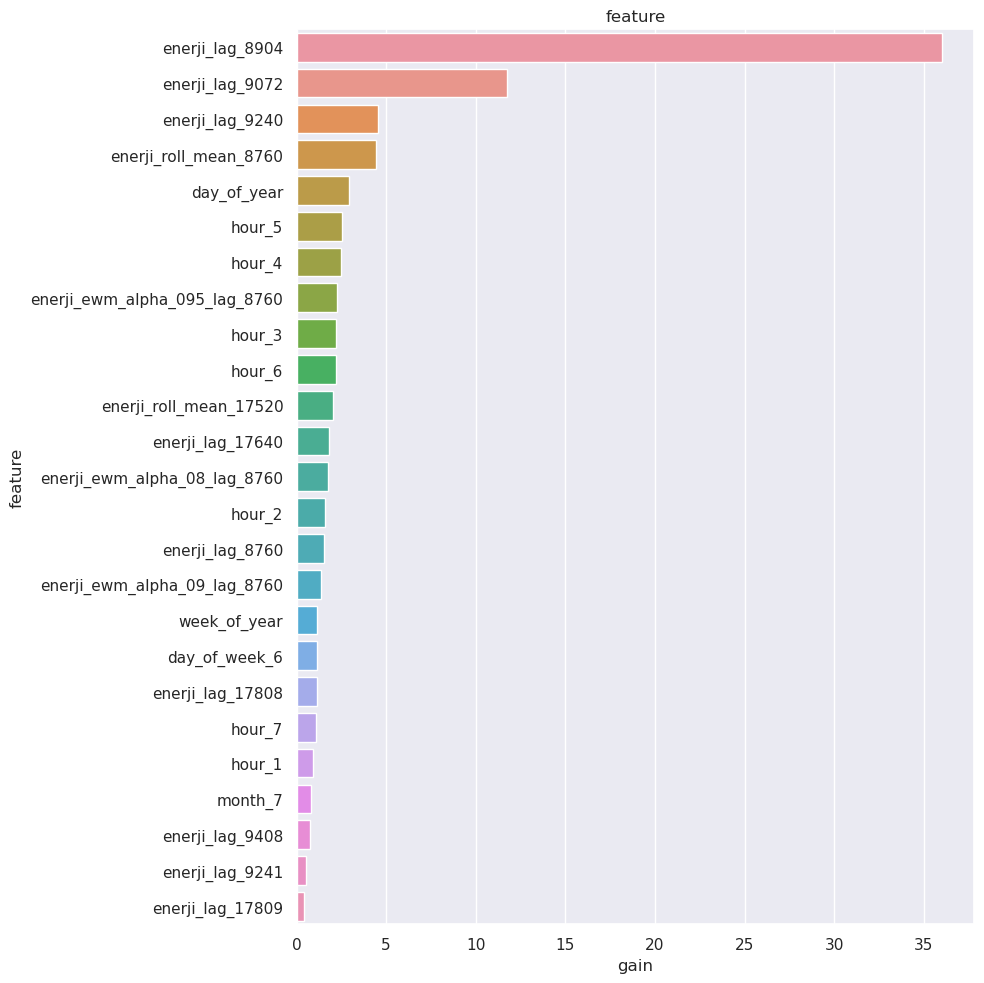

                    feature  split       gain
156         enerji_lag_8904    177  36.009915
324         enerji_lag_9072     67  11.746562
492         enerji_lag_9240     72   4.561748
1502  enerji_roll_mean_8760    334   4.418826
1               day_of_year    387   2.915841
...                     ...    ...        ...
119         enerji_lag_8867      3   0.015143
427         enerji_lag_9175      1   0.014975
176         enerji_lag_8924      3   0.014668
310         enerji_lag_9058      4   0.014139
771        enerji_lag_17534      1   0.014117

[200 rows x 3 columns]


503

In [54]:
plot_lgb_importances(model, num=30, plot=True)

feat_imp = plot_lgb_importances(model, num=200)

# önem seviyesine göre gain değerleri 0 olanlar seçilip modelden çıkartılması
importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values

imp_feats = [col for col in cols if col not in importance_zero]
len(imp_feats)

In [55]:
train = df.loc[~(df['Dağıtılan Enerji (MWh)'] == 0)]
Y_train = train['Dağıtılan Enerji (MWh)']
X_train = train[cols]
test = df.loc[df['Dağıtılan Enerji (MWh)'] == 0]
X_test = test[cols]

In [56]:
X_test.head()

day_of_month  day_of_year  week_of_year  is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  is_quarter_end  is_year_start  is_year_end  is_med  enerji_lag_8760  enerji_lag_8761  enerji_lag_8762  enerji_lag_8763  enerji_lag_8764  enerji_lag_8765  enerji_lag_8766  enerji_lag_8767  enerji_lag_8768  enerji_lag_8769  enerji_lag_8770  enerji_lag_8771  enerji_lag_8772  enerji_lag_8773  enerji_lag_8774  enerji_lag_8775  enerji_lag_8776  enerji_lag_8777  enerji_lag_8778  \
40152             1          213            31        0               1             0        3                 0               0              0            0       0      2568.225488      2724.259522      2845.216607      2963.887328      2997.433981      3050.659656      3123.464654      3180.240441      3198.920051      3211.509965      3225.770985      3167.255251      3068.258795      3013.697246      2861.598667      2649.572426      2354.945211      2047.626864      1972.380155   
40153             1          213            31        0               1             0        3                 0               0              0            0       0      2422.357420      2568.851159      2723.182465      2843.158113      2959.005190      2999.457774      3051.785534      3125.417932      3177.573874      3202.727358      3211.655755      3226.498294      3169.326533      3068.198754      3013.686512      2859.876203      2652.376519      2351.168161      2049.481488   
40154             1          213            31        0               1             0        3                 0               0              0            0       0      2287.804799      2419.986815      2571.781041      2727.858333      2843.633511      2963.762452      3000.472416      3050.345786      3122.586019      3178.659766      3203.630846      3210.815668      3224.989960      3166.676736      3068.997205      3016.059197      2858.477105      2652.817846      2350.761433   
40155             1          213            31        0               1             0        3                 0               0              0            0       0      2175.013726      2288.318829      2420.641671      2571.278608      2727.283618      2843.384782      2961.703966      3002.097625      3051.323292      3121.766026      3180.205975      3203.213561      3212.634415      3227.146896      3167.774089      3069.258923      3012.407418      2859.951579      2651.117388   
40156             1          213            31        0               1             0        3                 0               0              0            0       0      2082.622725      2172.614874      2288.990938      2422.089103      2571.376056      2725.257793      2845.348466      2963.794518      2998.919292      3047.025749      3122.858165      3178.772886      3200.911160      3211.545285      3223.841810      3167.931698      3065.386166      3012.468998      2862.106378   

       enerji_lag_8779  enerji_lag_8780  enerji_lag_8781  enerji_lag_8782  enerji_lag_8783  enerji_lag_8784  enerji_lag_8785  enerji_lag_8786  enerji_lag_8787  enerji_lag_8788  enerji_lag_8789  enerji_lag_8790  enerji_lag_8791  enerji_lag_8792  enerji_lag_8793  enerji_lag_8794  enerji_lag_8795  enerji_lag_8796  enerji_lag_8797  enerji_lag_8798  enerji_lag_8799  enerji_lag_8800  enerji_lag_8801  enerji_lag_8802  enerji_lag_8803  enerji_lag_8804  enerji_lag_8805  enerji_lag_8806  \
40152      2062.389485      2114.914946      2173.476372      2289.109069      2442.062522      2605.909868      2801.381147      2939.655351      3047.557275      3046.862553      3062.392818      3168.925681      3335.992647      3425.946695      3447.789585      3402.970272      3270.994843      3176.684385      3126.393687      2970.712219      2773.909896      2463.851924      2045.890336      1921.652802      1990.620798      2030.421078      2104.476854      2189.630598   
40153      1967.387957      2064.388045      2113.828988      2173.650988      2287.340402

In [57]:
Y_train.shape, X_train.shape, X_test.shape

((40152,), (40152, 1557), (744, 1557))

In [58]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.063081 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [59]:
df_test["Dağıtılan Enerji (MWh)"] = np.expm1(test_preds)

In [60]:
df_test.head()

,Dağıtılan Enerji (MWh)
Tarih,
2022-08-01 00:00:00,2219.603914
2022-08-01 01:00:00,2132.722857
2022-08-01 02:00:00,1920.006435
2022-08-01 03:00:00,1891.780864
2022-08-01 04:00:00,1863.483023


In [61]:
df_test.to_csv("submission.csv")

[542]	training's mape: 0.00717928	valid_1's mape: 0.0106979 Tersine logaritma alınarak 0.08989344920202877 ve submission 6.89243